# FRED data

In this notebook, we will prepare the dataset to evaluate economic regimes. We will use data from [FRED](https://fred.stlouisfed.org/).
We fetch all the economic indicators from a csv file uploaded [here](https://research.stlouisfed.org/econ/mccracken/fred-databases/) then going on, we use fredapi to pull down desired indicators without having to download updated versions every time.

In [34]:
import pandas as pd
import numpy as np
import api_config

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's look at the data

In [2]:
pd.read_csv('data/current_monthly.csv').head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


We see that there are 127 economic indicators available.
The first row shows the correct data transformation method for each indicator. Detailed information on the transformation code can be found in the [appendix](https://research.stlouisfed.org/econ/mccracken/fred-databases/).

We will save all the indicator names and the transform codes.

In [3]:
indicators = pd.read_csv('data/current_monthly.csv').iloc[0,1:]
indicators.head()

RPI                5.0
W875RX1            5.0
DPCERA3M086SBEA    5.0
CMRMTSPLx          5.0
RETAILx            5.0
Name: 0, dtype: object

## Load data using fredapi

Now we will save all the indicator names in a separate list, and download all the data using fredapi. To get an API key for yourself, go [here](https://fred.stlouisfed.org/docs/api/api_key.html).

In [26]:
indicator_names = indicators.index.to_list()

from fredapi import Fred
fred = Fred(api_key = api_config.fred_api_key)

df = pd.DataFrame()

for i in indicator_names:
    try:
        s = fred.get_series(i)
        s.name = i
        df = df.join(s, how='outer')
        df.index.name='Date'
    except Exception:
        pass
    
df.shape

(1248, 102)

We see now there are 102 indicators. We will ignore 25 indicators that couldn't be pulled down via fredapi.

If a row does not contain data of at least 80 indicators, remove.
Then we transform each indicator based on the transformation code saved in "indicators".

In [27]:
df = df.dropna(thresh=80)

for i in df.columns:
    code = indicators[i]
    if code == 1:
        df[i].apply(lambda x: x)
    elif code == 2:
        df[i] = df[i].diff()
    elif code == 3:
        df[i] = df[i].diff(periods=2)
    elif code == 4:
        df[i] = df[i].apply(np.log)
    elif code == 5:
        df[i] = df[i].apply(np.log)
        df[i] = df[i].diff(periods=2)
    elif code == 6:
        df[i] = df[i].apply(np.log)
        df[i] = df[i].diff(periods=2)
    elif code == 7:
        df[i] = df[i].pct_change()
        df[i] = df[i].diff()

Let's check if there are any NaN values

In [28]:
df.isnull().sum().sort_values(ascending=False).head()

ACOGNO      399
PERMITW      12
PERMIT       12
PERMITMW     12
PERMITS      12
dtype: int64

Let's first remove two rows and check again.

In [29]:
df = df.iloc[2:]
df.isnull().sum().sort_values(ascending=False).head(10)

ACOGNO           397
PERMIT            10
PERMITS           10
PERMITMW          10
PERMITNE          10
PERMITW           10
DTCTHFNM           1
DTCOLNVHFNM        1
CES0600000008      0
FEDFUNDS           0
dtype: int64

The lastest data for DTCTHFNM and DTCOLNVHFNM is missing so we'll remove the last row, and fill NaN values with 0.

In [30]:
df = df[:-1]
df = df.fillna(0)

## Add lag of the indicators

For example, a drop in indicator X 3 months ago might cause Y today. So we will add lag values - 1,3,6,12 months - for each indicator.

In [31]:
lags = [1,3,6,12]
newdf = pd.concat([df.shift(t).add_suffix(f"_lag_{t}M") for t in lags], axis=1)
df = pd.concat([df, newdf], axis=1)
df.dropna(inplace=True)

Let's print out the dataframe

In [32]:
df

,RPI,W875RX1,DPCERA3M086SBEA,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,...,PCEPI_lag_12M,DDURRG3M086SBEA_lag_12M,DNDGRG3M086SBEA_lag_12M,DSERRG3M086SBEA_lag_12M,CES0600000008_lag_12M,CES2000000008_lag_12M,CES3000000008_lag_12M,DTCOLNVHFNM_lag_12M,DTCTHFNM_lag_12M,INVEST_lag_12M
Date,,,,,,,,,,,,,,,,,,,,,
1960-03-01,0.003051,0.001833,0.018375,-0.017956,-0.009113,-0.004586,-0.010303,-0.033820,-0.001136,0.008611,...,0.001619,0.001826,-0.000337,0.003261,0.009346,0.000000,0.014599,0.004929,0.004138,-0.030921
1960-04-01,0.005328,0.004530,0.029396,-0.016979,-0.001141,0.000000,0.008030,-0.021152,0.019353,-0.008630,...,0.002674,0.002263,-0.000112,0.005276,0.009302,0.004057,0.014528,0.021992,0.015011,-0.020784
1960-05-01,0.005819,0.006057,-0.004988,-0.009103,0.007979,0.008011,0.012578,0.008267,0.013573,-0.007532,...,0.002548,0.002680,-0.000450,0.005091,0.009259,0.012171,0.004819,0.036955,0.023766,-0.011197
1960-06-01,0.003189,0.002195,-0.020563,-0.013795,-0.005726,-0.004602,-0.001143,-0.001192,-0.002258,-0.009797,...,0.003410,0.003655,0.001179,0.005248,0.004619,0.012073,0.004796,0.049509,0.034793,-0.038791
1960-07-01,0.002618,0.001653,0.001812,-0.016127,-0.017175,-0.017252,-0.016038,-0.049437,-0.003375,-0.025153,...,0.004954,0.002463,0.003257,0.007241,0.000000,0.012024,0.004796,0.054605,0.042800,-0.021701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,-0.006038,-0.005068,0.002718,-0.003117,-0.012318,-0.012458,-0.017898,-0.041147,-0.010945,-0.004579,...,0.010623,0.030312,0.007528,0.007698,0.010646,0.010240,0.012275,0.009419,0.006737,0.035144
2022-07-01,0.000669,0.001981,0.001989,0.003046,-0.003255,-0.002323,-0.007594,0.004986,-0.011341,0.004905,...,0.010113,0.016552,0.011179,0.008512,0.010210,0.011170,0.010520,0.002658,0.002439,0.020141
2022-08-01,0.006189,0.008060,0.004737,0.005021,0.006876,0.008746,0.004355,0.018110,0.000287,0.015260,...,0.008504,0.011939,0.010192,0.007336,0.010909,0.010786,0.010879,0.001787,0.000394,0.017247


## Recession Data

Let's add a column that contains the recession data to the dataframe created above. Again we use fredapi to fetch the recession data. The specific data we are going to use is 'NBER based Recession Indicators for the United States from the Period following the Peak through the Trough (USREC)'.

In [11]:
regime = pd.DataFrame(fred.get_series('USREC').rename('Regime'))
df = pd.concat((df,regime), axis=1, join='inner')
df.index.name = 'Date'

In the recession data, 1 means we're in a recession and 0 means we're not. Let's plot the recession data.

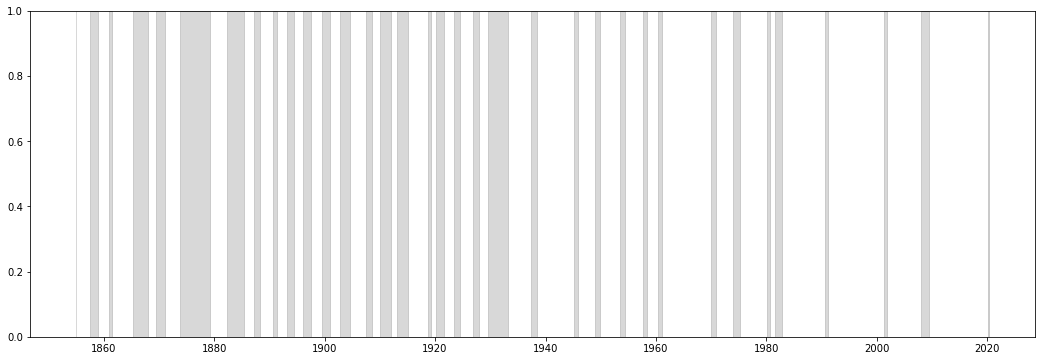

In [12]:
import matplotlib.pyplot as plt

startdates = []
enddates = []
prev_val = False

for index, val in regime.iterrows():
    if not prev_val and val['Regime'] == 1:
        startdates.append(index)
        prev_val = True
    
    if prev_val and val['Regime'] == 0:
        enddates.append(index)
        prev_val = False
        
if len(startdates) != len(enddates):
    enddates.append(regime.index[-1])
    
crash_dates = list(zip(startdates, enddates))

plt.figure(figsize=(18, 6))
for (start, end) in crash_dates:
    plt.axvspan(start, end, color='gray', alpha=0.3)

## Define Functions

Let's define fuctions that we're going to use frequently for further research. We are going to put these function into a .py file.

In [13]:
def get_macro_indicators():
    return pd.read_csv('data/current_monthly.csv').iloc[0,1:]

In [14]:
def fred_data():
    
    indicators = get_macro_indicators()    
    indicator_names = indicators.index.to_list()

    df = pd.DataFrame()

    for i in indicator_names:
        try:
            s = fred.get_series(i)
            s.name = i
            df = df.join(s, how='outer')
            df.index.name='Date'
        except Exception:
            pass
        
    df = df.dropna(thresh=80)

    for i in df.columns:
        code = indicators[i]
        if code == 1:
            df[i].apply(lambda x: x)
        elif code == 2:
            df[i] = df[i].diff()
        elif code == 3:
            df[i] = df[i].diff(periods=2)
        elif code == 4:
            df[i] = df[i].apply(np.log)
        elif code == 5:
            df[i] = df[i].apply(np.log)
            df[i] = df[i].diff(periods=2)
        elif code == 6:
            df[i] = df[i].apply(np.log)
            df[i] = df[i].diff(periods=2)
        elif code == 7:
            df[i] = df[i].pct_change()
            df[i] = df[i].diff()
    
    df = df.iloc[2:-1]
    df = df.fillna(0)
    
    lags = [1,3,6,12]
    newdf = pd.concat([df.shift(t).add_suffix(f"_lag_{t}M") for t in lags], axis=1)
    df = pd.concat([df, newdf], axis=1)
    df.dropna(inplace=True)
    
    regime = pd.DataFrame(fred.get_series('USREC').rename('Regime'))

    df = pd.concat((df,regime), axis=1, join='inner')
    df.index.name='Date'
    
    return df

In [15]:
def plot_regime(regime):
    startdates = []
    enddates = []
    prev_val = False

    for index, val in regime.iterrows():
        if not prev_val and val['Regime'] == 1:
            startdates.append(index)
            prev_val = True

        if prev_val and val['Regime'] == 0:
            enddates.append(index)
            prev_val = False

    if len(startdates) != len(enddates):
        enddates.append(regime.index[-1])

    crash_dates = list(zip(startdates, enddates))

    plt.figure(figsize=(18, 6))
    
    for (start, end) in crash_dates:
        plt.axvspan(start, end, color='gray', alpha=0.3)

Let's save our dataframe as csv for future use. It should be quicker than pulling data from fredapi each time.

In [16]:
df.to_csv('data/fred_data.csv')

In [22]:
dff = pd.read_csv('data/fred_data.csv', index_col = 'Date', parse_dates = ['Date'])

In [23]:
dff.loc['1960']

,RPI,W875RX1,DPCERA3M086SBEA,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,...,DDURRG3M086SBEA_lag_12M,DNDGRG3M086SBEA_lag_12M,DSERRG3M086SBEA_lag_12M,CES0600000008_lag_12M,CES2000000008_lag_12M,CES3000000008_lag_12M,DTCOLNVHFNM_lag_12M,DTCTHFNM_lag_12M,INVEST_lag_12M,Regime
Date,,,,,,,,,,,,,,,,,,,,,
1960-03-01,0.003051,0.001833,0.018375,-0.017956,-0.009113,-0.004586,-0.010303,-0.033820,-0.001136,0.008611,...,0.001826,-0.000337,0.003261,0.009346,0.000000,0.014599,0.004929,0.004138,-0.030921,0.0
1960-04-01,0.005328,0.004530,0.029396,-0.016979,-0.001141,0.000000,0.008030,-0.021152,0.019353,-0.008630,...,0.002263,-0.000112,0.005276,0.009302,0.004057,0.014528,0.021992,0.015011,-0.020784,0.0
1960-05-01,0.005819,0.006057,-0.004988,-0.009103,0.007979,0.008011,0.012578,0.008267,0.013573,-0.007532,...,0.002680,-0.000450,0.005091,0.009259,0.012171,0.004819,0.036955,0.023766,-0.011197,1.0
1960-06-01,0.003189,0.002195,-0.020563,-0.013795,-0.005726,-0.004602,-0.001143,-0.001192,-0.002258,-0.009797,...,0.003655,0.001179,0.005248,0.004619,0.012073,0.004796,0.049509,0.034793,-0.038791,1.0
1960-07-01,0.002618,0.001653,0.001812,-0.016127,-0.017175,-0.017252,-0.016038,-0.049437,-0.003375,-0.025153,...,0.002463,0.003257,0.007241,0.000000,0.012024,0.004796,0.054605,0.042800,-0.021701,1.0
1960-08-01,0.000202,-0.000662,0.001044,-0.004641,-0.008071,-0.005784,-0.006886,-0.027729,0.002258,-0.025487,...,-0.004181,0.002914,0.006521,0.000000,0.011929,-0.009615,0.049502,0.041298,-0.017855,1.0
1960-09-01,-0.000354,-0.002274,0.003778,-0.011684,-0.010443,-0.005817,-0.002311,-0.001236,-0.003389,-0.022403,...,-0.002953,0.004531,0.005894,0.000000,0.011881,-0.004796,0.035942,0.034111,-0.027018,1.0
1960-10-01,0.004224,0.003430,0.009617,-0.011693,-0.002317,-0.001162,0.005742,-0.001222,0.006742,-0.016980,...,0.000999,0.005024,0.006307,0.000000,0.011788,0.000000,0.021253,0.024419,-0.014082,1.0
1960-11-01,-0.001289,-0.002611,0.001365,-0.015394,-0.004681,-0.007027,-0.008135,-0.022529,0.000000,-0.010243,...,0.000087,0.000725,0.005945,0.000000,0.011742,-0.004819,0.007412,0.016845,-0.013266,1.0
